In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm
from tsfresh.feature_extraction import extract_features
from multiprocessing import Pool
tqdm.pandas(desc="apply progress")

/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data_dir = "/Users/hidehisa/.kaggle/competitions/plasticc"
train = pd.read_csv(data_dir + "/train_with_cluster.csv")
meta = pd.read_csv(data_dir + "/training_set_metadata.csv")

## Common functions 

### Loss

In [3]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {
        6: 1,
        15: 2,
        16: 1,
        42: 1,
        52: 1,
        53: 1,
        62: 1,
        64: 2,
        65: 1,
        67: 1,
        88: 1,
        90: 1,
        92: 1,
        95: 1
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {
        6: 1,
        15: 2,
        16: 1,
        42: 1,
        52: 1,
        53: 1,
        62: 1,
        64: 2,
        65: 1,
        67: 1,
        88: 1,
        90: 1,
        92: 1,
        95: 1
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

### Plot 

In [4]:
def save_importances(importances_, top=True, figname="importances.png"):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 12))
    data = importances_.sort_values('mean_gain', ascending=False)[:300] if top else importances_.sort_values('mean_gain', ascending=True)[:300]
    sns.barplot(
        x='gain',
        y='feature',
        data=data)
    plt.tight_layout()
    plt.savefig(figname)


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def save_cm(y, oof_preds, path, figname="confusion_matrix.png"):
    unique_y = np.unique(y)
    class_map = dict()
    for i, val in enumerate(unique_y):
        class_map[val] = i

    y_map = np.zeros((y.shape[0], ))
    y_map = np.array([class_map[val] for val in y])

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds, axis=-1))
    np.set_printoptions(precision=2)

    sample_sub = pd.read_csv(path)
    class_names = list(sample_sub.columns[1:-1])
    del sample_sub

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(12, 12))
    plot_confusion_matrix(
        cnf_matrix,
        classes=class_names,
        normalize=True,
        title='Confusion matrix')
    plt.savefig(figname)

## previous

In [5]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected,cluster
0,615,59750.4229,2,-544.810303,3.622952,1,2
1,615,59750.4306,1,-816.434326,5.553370,1,2
2,615,59750.4383,3,-471.385529,3.801213,1,2
3,615,59750.4450,4,-388.984985,11.395031,1,2
4,615,59752.4070,2,-681.858887,4.041204,1,2


### Features 

In [73]:
def basic(d):
    df = d.copy()
    df["flux_ratio_sq"] = np.power(df["flux"] / df["flux_err"], 2)
    df["flux_by_flux_ratio_sq"] = df["flux"] * df["flux_ratio_sq"]

    aggs = {
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'detected': ['mean'],
        'flux_ratio_sq': ['sum', 'skew'],
        'flux_by_flux_ratio_sq': ['sum', 'skew'],
    }
    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    agg_df.columns = new_columns
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    agg_df['flux_dif2'] = (
        agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df[
        'flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (
        agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']
    
    agg_flux_diff = agg_df.reset_index()[["object_id", "flux_diff"]]
    df2 = pd.merge(df, agg_df, how="left", on="object_id")
    df2["flux_norm"] = df2.flux / df2.flux_diff
    del df2["flux"]
    
    idxmax_df = df.groupby("object_id").agg({"flux": "idxmax"})
    idxmax_df.rename(columns={"flux": "flux_idxmax"}, inplace=True)
    df3 = pd.merge(df, idxmax_df, how="left", on="object_id")
    df3.drop(["cluster", "flux_err", "detected"], axis=1, inplace=True)
    df3["dummy_index"] = df3.index
    df3["index_diff"] = df3.dummy_index - df3.flux_idxmax
    df3 = df3.query("index_diff >= 0 & index_diff < 100")
    df3 = df3[["object_id", "flux", "passband", "mjd"]]
    df3_mindf = df3.groupby("object_id").agg({
        "flux": "min"
    })
    df3_mindf.rename(columns={"flux": "flux_min"}, inplace=True)
    df3 = pd.merge(df3, df3_mindf, how="left", on="object_id")
    df3["flux"] = df3["flux"] - df3["flux_min"]
    df3["log_flux"] = np.log(df3.flux + 0.01)

    fcp = {
        'fft_coefficient': [{
            'coeff': 0,
            'attr': 'abs'
        }, {
            'coeff': 1,
            'attr': 'abs'
        }],
        'kurtosis':
        None,
        'skewness':
        None,
        'cid_ce': [{"normalize": True}]
    }
    fcp2 = {
        'fft_coefficient': [{
            'coeff': 0,
            'attr': 'abs'
        }, {
            'coeff': 1,
            'attr': 'abs'
        }],
        'abs_energy': None,
        'sample_entropy': None
    }
    fcp3 = {
        'linear_trend': [{
            'attr': 'pvalue'
        }, {
            'attr': 'intercept'
        }, {
            'attr': 'slope'
        }]
    }
    fcp_flux = {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'cid_ce': [{"normalize": True}]
    }
    fcp_flux_by_flux_ratio_sq = {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        
    }
    agg_df_ts = extract_features(
        df,
        column_id='object_id',
        column_sort='mjd',
        column_kind='passband',
        column_value='flux',
        default_fc_parameters=fcp,
        n_jobs=2)
    agg_df_ts2 = extract_features(
        df2,
        column_id = 'object_id',
        column_sort='mjd',
        column_kind='passband',
        column_value='flux_norm',
        default_fc_parameters=fcp2,
        n_jobs=2
    )
    agg_df_ts3 = extract_features(
        df3,
        column_id='object_id',
        column_sort='mjd',
        column_kind='passband',
        column_value='log_flux',
        default_fc_parameters=fcp3,
        n_jobs=2
    )
    agg_df_flux = extract_features(
        df,
        column_id='object_id',
        column_value='flux',
        default_fc_parameters=fcp_flux,
        n_jobs=2
    )
    agg_df_ffrs = extract_features(
        df,
        column_id='object_id',
        column_value='flux_by_flux_ratio_sq',
        default_fc_parameters=fcp_flux_by_flux_ratio_sq,
        n_jobs=2
    )
    
    df_det = df[df['detected'] == 1].copy()
    agg_df_mjd = extract_features(
        df_det,
        column_id='object_id',
        column_value='mjd',
        default_fc_parameters={
            'maximum': None,
            'minimum': None
        },
        n_jobs=2)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd[
        'mjd__minimum']
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts2.columns = pd.Index([e + "_norm" for e in agg_df_ts2.columns])
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd, on='id')
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ts2, on='id')
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ts3, on='id')
    agg_df_ts = pd.merge(agg_df_ts, agg_df_flux, on='id')
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ffrs, on='id')
    # tsfresh returns a dataframe with an index name='id'
    agg_df_ts.index.rename('object_id', inplace=True)
    agg_df = pd.merge(agg_df, agg_df_ts, on='object_id')
    return agg_df


def cluster_mean_diff(df):
    new_df = df.groupby(["object_id", "cluster"]).agg({
        "flux": ["mean", "max", "min"]
    })
    new_df.columns = pd.Index(
        [e[0] + "_" + e[1] for e in new_df.columns.tolist()])
    new_df["normalized_mean"] = new_df["flux_mean"] / (
        new_df["flux_max"] - new_df["flux_min"])
    new_df.reset_index(inplace=True)
    return new_df.groupby("object_id").agg({"normalized_mean": "std"})


def passband_std_difference(df):
    std_df = df.groupby(["object_id", "cluster", "passband"]).agg({
        "flux": "std"
    }).reset_index().groupby(["object_id",
                              "passband"])["flux"].mean().reset_index()
    std_df_max = std_df.groupby("object_id")["flux"].max()
    std_df_min = std_df.groupby("object_id")["flux"].min()
    return (std_df_max / std_df_min).reset_index()


def linear_slope(df):
    new_df = df.groupby(["object_id", "cluster", "passband"]).agg({
        "flux": ["max", "min"]
    })
    new_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_df.columns])
    new_df.reset_index(inplace=True)
    new_df["flux_range"] = new_df["flux_max"] - new_df["flux_min"]
    new_df = pd.merge(
        df, new_df, how="left", on=["object_id", "cluster", "passband"])
    new_df["flux_normalized"] = new_df["flux"] / new_df["flux_range"]
    lr = LinearRegression()

    def get_coef_(x):
        if x.shape[0] <= 1:
            return 0
        lr.fit(
            x.mjd.values.reshape([-1, 1]),
            x.flux_normalized.values.reshape([-1, 1]))
        return lr.coef_[0][0]

    new_df = new_df.groupby(
        ["object_id", "cluster", "passband"],
        as_index=False)["object_id", "cluster", "passband", "mjd",
                        "flux_normalized"].progress_apply(
                            lambda x: get_coef_(x)).unstack().groupby(
                                "object_id").mean().reset_index()
    new_df.columns = pd.Index(
        [new_df.columns.name + str(e) for e in new_df.columns])
    new_df.rename(columns={"passbandobject_id": "object_id"}, inplace=True)
    return new_df


def linear_slope_multi(d):
    n_record = d.shape[0]
    default_chunk = n_record // 8
    head = 0
    df_pool = []
    for _ in range(7):
        new_df = d.loc[head:head+default_chunk, :]
        last_id = new_df.object_id.unique()[-1]
        len_last = new_df.query("object_id == @last_id").shape[0]
        new_df = new_df.loc[head:head+default_chunk-len_last, :]
        df_pool.append(new_df)
        head = head + default_chunk - len_last+1
    df_pool.append(d.loc[head:, :])
    pool = Pool(8)
    dfs = pool.map(linear_slope, df_pool)
    pool.close()
    return pd.concat(dfs)


def num_outliers(df):
    new_df = df.groupby("object_id").agg({"flux": ["mean", "std"]})
    new_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_df.columns])
    new_df["upper_sigma"] = new_df["flux_mean"] + new_df["flux_std"]
    new_df["upper_2sigma"] = new_df["flux_mean"] + 2 * new_df["flux_std"]
    new_df["lower_sigma"] = new_df["flux_mean"] - new_df["flux_std"]
    new_df["lower_2sigma"] = new_df["flux_mean"] - 2 * new_df["flux_std"]
    new_df.drop(["flux_mean", "flux_std"], axis=1, inplace=True)
    new_df = pd.merge(df, new_df, how="left", on="object_id")
    new_df["outside_sigma"] = (
        (new_df["flux"] > new_df["upper_sigma"]) |
        (new_df["flux"] < new_df["lower_sigma"])).astype(int)
    new_df["outside_2sigma"] = (
        (new_df["flux"] > new_df["upper_2sigma"]) |
        (new_df["flux"] < new_df["lower_2sigma"])).astype(int)

    return_df = new_df.groupby("object_id").agg({
        "outside_sigma": "sum",
        "outside_2sigma": "sum"
    })
    return_df.reset_index(inplace=True)
    return return_df

In [8]:
def haversine_plus(lon1, lat1, lon2, lat2):
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)
    
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)
    
    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),
               np.multiply(np.cos(lat1),
                           np.multiply(np.cos(lat2),
                                       np.power(np.sin(np.divide(dlon, 2)), 2))))
    haversine = np.multiply(2, np.arcsin(np.sqrt(a)))
    return {
        'haversine': haversine,
        'latlon1': np.subtract(np.multiply(lon1, lat1), np.multiply(lon2, lat2))
    }


def process_meta(meta):
    meta_dict = dict()
    meta_dict.update(haversine_plus(meta['ra'].values, meta['decl'].values,
                                    meta['gal_l'].values, meta['gal_b'].values))
    meta_dict['hostgal_photoz_certain'] = np.multiply(
        meta['hostgal_photoz'].values,
        np.exp(meta['hostgal_photoz_err']).values
    )
    meta_df = pd.concat([meta, pd.DataFrame(meta_dict, index=meta.index)], axis=1)
    return meta_df

In [24]:
def get_full(df, meta):
    agg_basic = basic(df)
    # agg_cluster = with_cluster(df)

    cl_mean_diff = cluster_mean_diff(df)
    ps_std_diff = passband_std_difference(df)
    #lin_sl = linear_slope(df)
    num_out = num_outliers(df)

    # full = pd.merge(agg_basic, agg_cluster, how="left", on="object_id")
    full = pd.merge(agg_basic, cl_mean_diff, how="left", on="object_id")
    full = pd.merge(full, ps_std_diff, how="left", on="object_id")
    #full = pd.merge(full, lin_sl, how="left", on="object_id")
    full = pd.merge(full, num_out, how="left", on="object_id")
    meta = process_meta(meta)

    full = pd.merge(full, meta, how="left", on="object_id")
    if "target" in full.columns:
        full.drop("target", axis=1, inplace=True)
    return full


def train_data(df, meta):
    full = get_full(df, meta)
    y = meta.target
    classes = sorted(y.unique())
    class_weight = {c: 1 for c in classes}

    for c in [64, 15]:
        class_weight[c] = 2
    oof_df = full[["object_id"]]
    del full['object_id'], full['distmod'], full['hostgal_specz']
    del full['ra'], full['decl'], full['gal_l'], full['gal_b'], full['ddf']
    return full, y, classes, class_weight, oof_df

In [74]:
%%time
full, y, classes, class_weight, oof_df = train_data(train, meta)

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00,  8.84it/s]


CPU times: user 51.6 s, sys: 5.86 s, total: 57.4 s
Wall time: 1min 41s


In [75]:
train_mean = full.mean(axis=0)
full.fillna(0, inplace=True)

In [76]:
full.head()

,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,...,normalized_mean,flux,outside_sigma,outside_2sigma,hostgal_photoz,hostgal_photoz_err,mwebv,haversine,latlon1,hostgal_photoz_certain
0,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835268,...,0.055573,8.087118,115,17,0.0000,0.0000,0.017,0.319006,-1.528827,0.000000
1,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,...,0.375140,2.071484,136,4,1.6267,0.2552,0.007,1.698939,3.258921,2.099614
2,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,...,0.083515,5.680921,31,18,0.2262,0.0157,0.021,1.818030,3.128522,0.229779
3,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,...,0.075897,5.988327,21,15,0.2813,1.1523,0.007,0.495223,6.893743,0.890445
4,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,...,0.074476,6.711240,27,12,0.2415,0.0176,0.024,0.395162,-1.928064,0.245788


### Train

In [77]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
importances = pd.DataFrame()

lgb_params = {
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 14, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 7, 
    'n_estimators': 500, 
    'subsample_freq': 2, 
    'subsample_for_bin': 5000, 
    'min_data_per_group': 100, 
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5, 
    'max_cat_threshold': 32, 
    'metric_freq': 10, 
    'verbosity': -1, 
    'metric': 'multi_logloss', 
    'xgboost_dart_mode': False, 
    'uniform_drop': False, 
    'colsample_bytree': 0.5, 
    'drop_rate': 0.173, 
    'learning_rate': 0.0267, 
    'max_drop': 5, 
    'min_child_samples': 10, 
    'min_child_weight': 100.0, 
    'min_split_gain': 0.1, 
    'num_leaves': 7, 
    'reg_alpha': 0.1, 
    'reg_lambda': 0.00023, 
    'skip_drop': 0.44, 
    'subsample': 0.75
}

# Compute weights
w = y.value_counts()
weights = {i: np.sum(w) / w[i] for i in w.index}
oof_preds = np.zeros((len(full), np.unique(y).shape[0]))

for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = full.iloc[trn_], y.iloc[trn_]
    val_x, val_y = full.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x,
        trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights))
    oof_preds[val_, :] = clf.predict_proba(
        val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, oof_preds[val_, :]))

    imp_df = pd.DataFrame()
    imp_df['feature'] = full.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)

print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(
    y_true=y, y_preds=oof_preds))
with open("log.txt", "a") as f:
    f.write(f"TITLE: rsigma added. LOSS: {multi_weighted_logloss(y_true=y, y_preds=oof_preds):.5f}\n")

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.711942	training's wloss: 0.702682	valid_1's multi_logloss: 1.05764	valid_1's wloss: 0.875534
[200]	training's multi_logloss: 0.448398	training's wloss: 0.437598	valid_1's multi_logloss: 0.824618	valid_1's wloss: 0.673439
[300]	training's multi_logloss: 0.343293	training's wloss: 0.331836	valid_1's multi_logloss: 0.739226	valid_1's wloss: 0.621622
[400]	training's multi_logloss: 0.282781	training's wloss: 0.271611	valid_1's multi_logloss: 0.692374	valid_1's wloss: 0.605326
[500]	training's multi_logloss: 0.240262	training's wloss: 0.229662	valid_1's multi_logloss: 0.663421	valid_1's wloss: 0.601698
Did not meet early stopping. Best iteration is:
[500]	training's multi_logloss: 0.240262	training's wloss: 0.229662	valid_1's multi_logloss: 0.663421	valid_1's wloss: 0.601698
0.6016980771702699
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.71644	tr

/Users/hidehisa/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Normalized confusion matrix


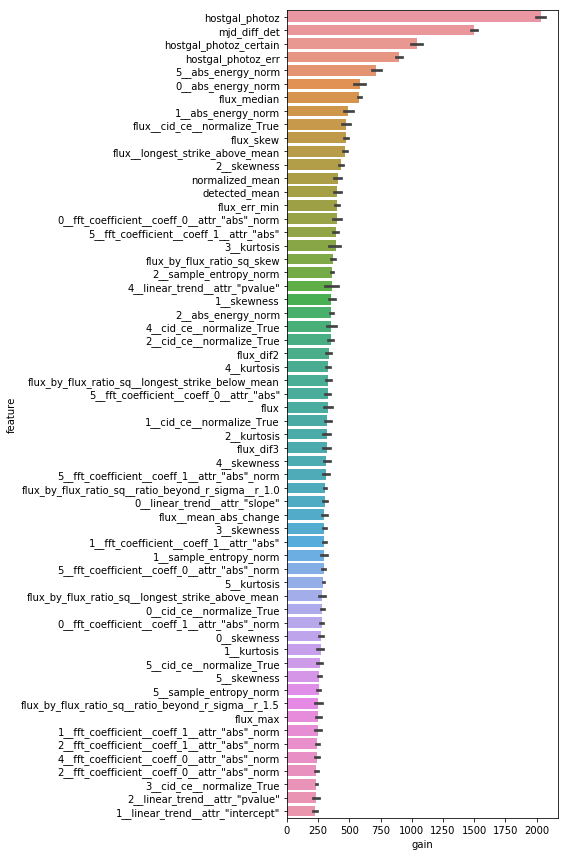

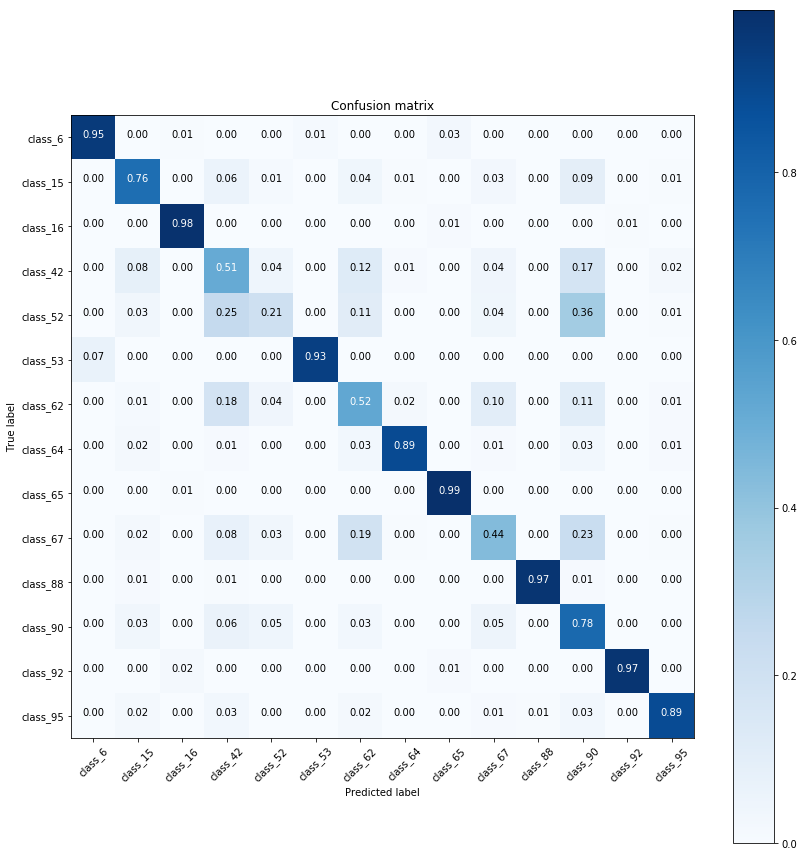

In [78]:
save_importances(importances_=importances, top=True, figname="importances_.png")
save_cm(y, oof_preds, data_dir + "/sample_submission.csv", figname="confusion_mat.png")